In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()


######## Functions for detrending xr.DataArrays #############
def get_linear_fit(data, dim="time"):
    """Remove linear trend from xr.DataArray along specified dimensions"""

    ## Get coefficients of linear fit
    p = data.polyfit(dim=dim, deg=1)

    ## Compute linear fit
    fit = xr.polyval(data[dim], p["polyfit_coefficients"])

    return fit


def get_linear_fit_with_cycle(data):
    """compute linear trend for each month separately"""
    linear_fit = data.groupby("time.month").map(get_linear_fit)
    return linear_fit


############################################################


def make_plot(data, data_fit, data_anom):
    """Plot results of detrending"""
    fig, [ax, ax1] = plt.subplots(1, 2, figsize=(8, 3.5))

    # plot y=0 line
    ax.axhline(0, c="k", lw=1)
    ax1.axhline(0, c="k", lw=1)

    ## Plot data
    for i in np.arange(len(data.x)):
        label = r"$x=$" + f"{data.x.isel(x=i).values.item()}"

        ## plot data
        data_plot = ax.plot(data.time, data.isel(x=i), label=label, alpha=0.5)

        ## plot best linear fit
        fit_plot = ax.plot(
            data.time, data_fit.isel(x=i), c=data_plot[0].get_color(), ls="--", lw=1
        )

        ## Plot anomaly
        anom_plot = ax1.plot(data.time, data_anom.isel(x=i), label=label)

    # annotate graphs
    ax.set_xticks(ticks=ax.get_xticks(), labels=ax.get_xticklabels(), rotation=45)
    ax1.set_xticks(ticks=ax1.get_xticks(), labels=ax1.get_xticklabels(), rotation=45)

    ax.set_title("Raw data and best fit")
    ax1.set_title("Anomalies after detrending")
    ax.set_ylabel("Value")
    ax.set_xlabel("Year")
    ax1.set_xlabel("Year")

    ax.legend()

    return fig, [ax, ax1]


def make_random_data(nyears=4, nx=3):
    """
    Create synthetic data with seasonal cycle and linear trend.
    -'nyears' is the number of years
    -'nx' is the number of gridpoints
    Returns xr.DataArray
    """

    ## create space and time dimensions
    t = pd.date_range(start="1980-01-01", freq="1M", periods=12 * nyears)
    year = np.array(t.year).astype(float)
    month = np.array(t.month).astype(float)
    x = np.linspace(0, 180, nx)

    ## slope and intercept of data at each gridpoint
    m = 0.05 * np.random.randn(*x.shape)
    b = np.random.randn(*x.shape)

    ## seasonal cycle
    cycle = np.cos(month / 12 * (2 * np.pi))

    ## create synthetic data
    # first, linear trend
    months_elapsed = np.arange(len(t))
    data = (m[None, :] * months_elapsed[:, None]) + b[None, :]

    # next, add seasonal cycle
    data = data + cycle[:, None]

    # next, add noise
    data = data + 0.5 * np.random.randn(*data.shape)

    # put in dataarray format
    data = xr.DataArray(data, coords={"time": t, "x": x}, dims=["time", "x"])

    return data

#### Generate random data

In [2]:
data = make_random_data()

#### Only remove linear trend (not seasonal cycle)

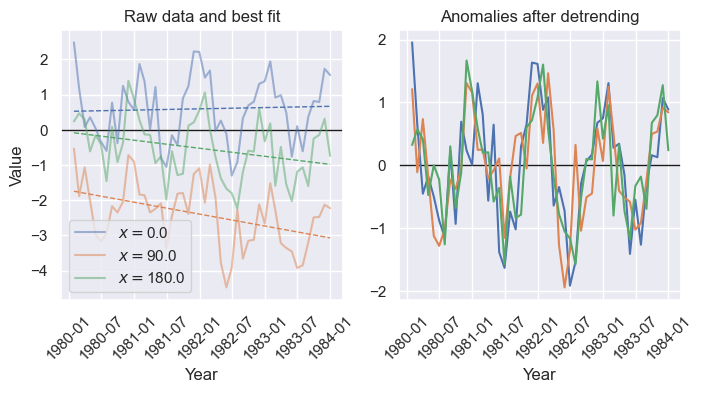

In [3]:
data_fit = get_linear_fit(data)
data_anom = data - data_fit
fig, axs = make_plot(data, data_fit, data_anom)

#### Remove linear trend and seasonal cycle

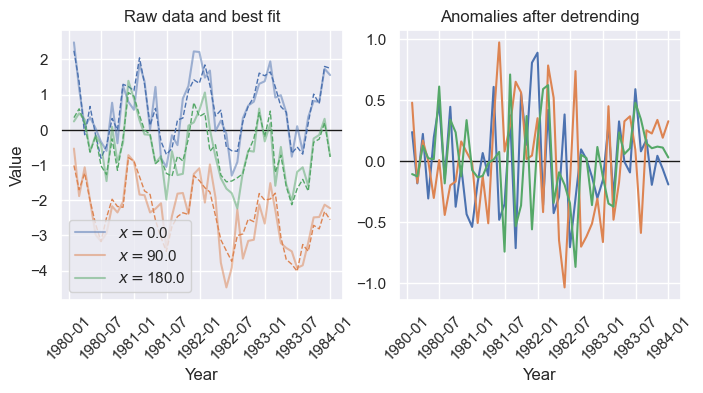

In [4]:
data_fit = get_linear_fit_with_cycle(data)
data_anom = data - data_fit
fig, axs = make_plot(data, data_fit, data_anom)